In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
from dask.distributed import Client
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [3]:
from distributed import Client

client = Client(n_workers=15, threads_per_worker=1, memory_limit='20GB')

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41918 instead
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41918/status,
Dashboard: http://127.0.0.1:41918/status,Workers: 15
Total threads: 15,Total memory: 279.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44417,Workers: 15
Dashboard: http://127.0.0.1:41918/status,Total threads: 15
Started: Just now,Total memory: 279.40 GiB
Comm: tcp://127.0.0.1:38505,Total threads: 1
Dashboard: http://127.0.0.1:44202/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:42143,


In [5]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp
from evaluate import half_eval as half_eval

In [6]:
%%time
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource")

CPU times: user 4.02 s, sys: 229 ms, total: 4.25 s
Wall time: 4.14 s


In [7]:
%%time
fgk_object = lsdb.read_hipscat("/nvme/users/atzanida/tmp/sample_final_starhorse_hips")

CPU times: user 19.9 ms, sys: 8.32 ms, total: 28.2 ms
Wall time: 22.9 ms


In [8]:
%%time
_sources = fgk_object.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/join_catalog_data.py:195: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 14 s, sys: 1.34 s, total: 15.3 s
Wall time: 14.7 s


## Gaussian Fitting Testing

In [1447]:
# SNAD candidates for good validation
# 591213300052934, 744110200006424, 387204400022186, 604210100001134, 588206200029611,453206400001919,  

In [1467]:
lc_demo = ascii.read("https://ztf.snad.space/dr17/csv/591213300052934")
_t, _mag, _magerr = lc_demo['mjd'].data, lc_demo['mag'].data, lc_demo['magerr'].data

In [1468]:
x, y, z = my_tools.prepare_lc(_t, _mag, _magerr, 
                              np.zeros(len(_t)),
                              np.array(['r' for _ in range(len(_t))]))

In [1469]:
#y[x>58_000] += np.random.normal(0, 5.2, len(x[x>58_000]))

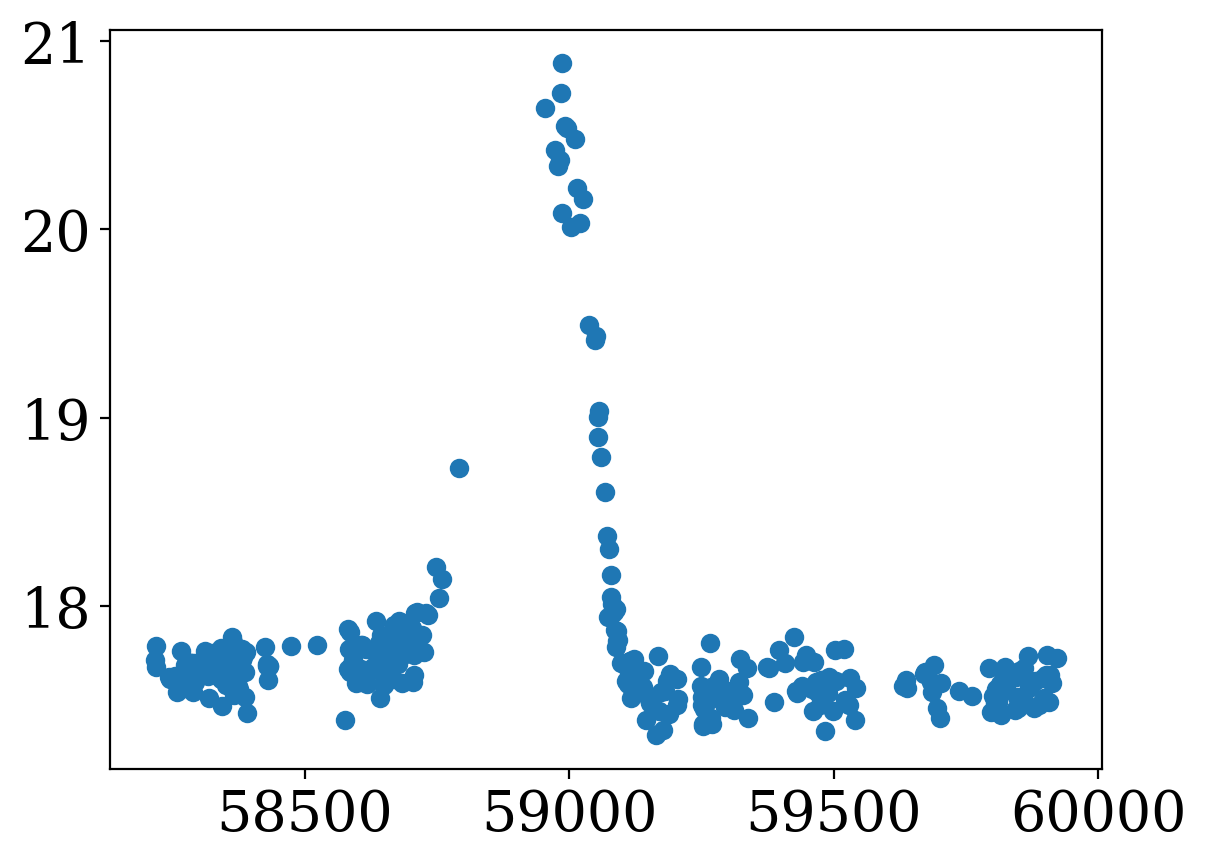

In [1470]:
plt.scatter(x, y)

In [1471]:
def gaus(x, a, x0, sigma, ofs):
    """"Calculate a simple Gaussian function with a term offset"""
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + ofs

def auto_fit(x, y, loc, base, return_model=False):
    """Perform a Gaussian function auto fitting with some lose priors."""
    popt, pcov = curve_fit(gaus, 
                            x,
                            y,
                            p0=[1, loc, 1, base],
                          bounds=((0.1, loc-5, 0.1, base-2),
                                  (np.inf, loc+5, np.inf, base+2)))
    
    if return_model:
        return gaus(x, *popt)
    else:
        return popt

def fwhm_calc(pop):
    """Add parameters recovered"""
    return 2.355 * pop[2] # fwhm 

def calc_sum_score(xdat, ydat, peak_dict, base, rms):
    """Calculate score"""
    score_term = 0
    for i in range(peak_dict[0]):
        event = peak_detections[1][f'dip_{i}']
        loc = event['peak_loc']
        powr = event['dip_power']
        Ndet = event['N_1sig_in_dip']
        
        fit_temrs = auto_fit(xdat, ydat,
                             loc, base, return_model=False)
        fwhm = fwhm_calc(fit_temrs)
        
        score_term += fwhm * powr * Ndet
        
    return (1/(peak_dict[0])) * (1/rms) * score_term

In [1472]:
import astropy.stats as astro_stats
R, S = astro_stats.biweight.biweight_location(y), astro_stats.biweight.biweight_scale(y)
running_deviation = dip_pipeline.deviation(y, z, R, S)

peak_detections = dip_pipeline.peak_detector(x, 
                                             running_deviation, 
                                             power_thresh=4, peak_close_rmv=20, pk_2_pk_cut=20)

In [1473]:
peak_detections[0]

1

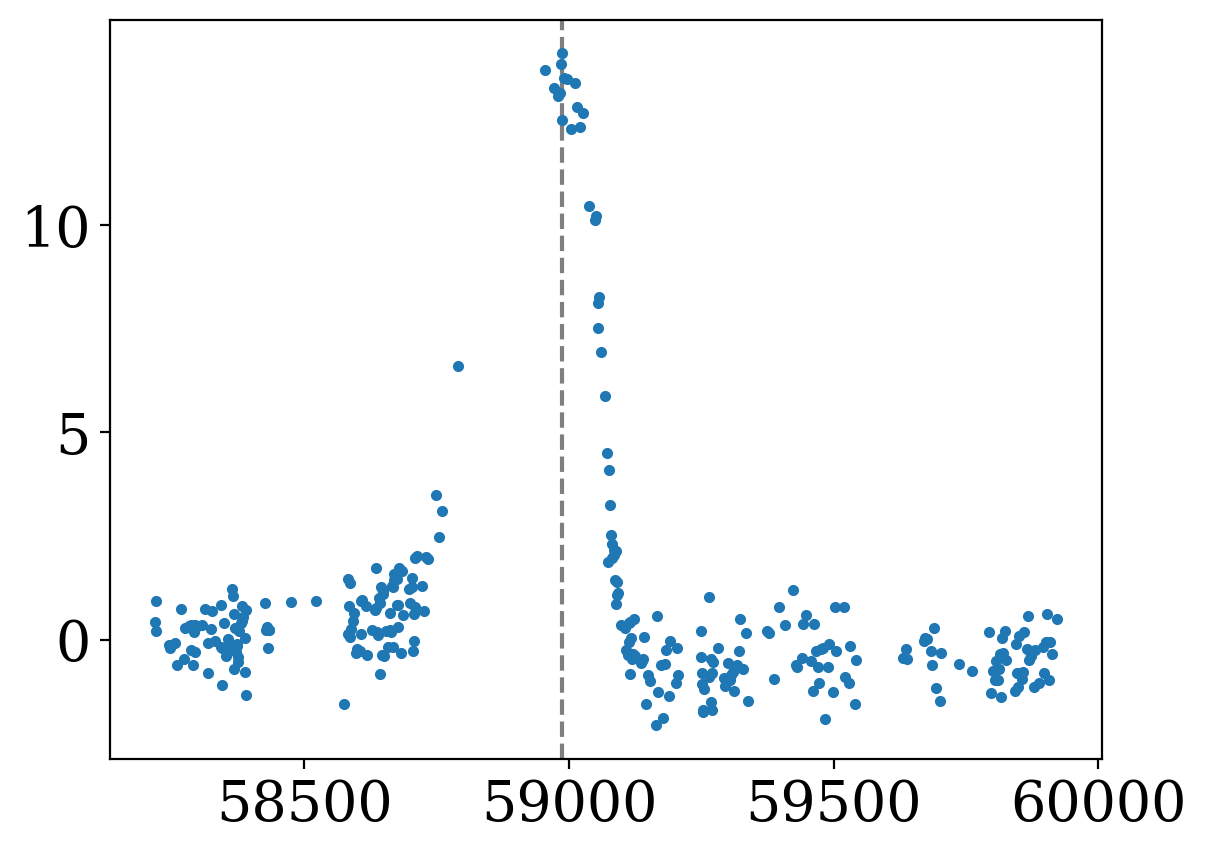

In [1474]:
plt.errorbar(x, running_deviation, fmt='.')
for i in range(peak_detections[0]):
    event = peak_detections[1][f'dip_{i}']
    
    
    plt.axvline(event['peak_loc'], color='k', ls='--', alpha=0.5)

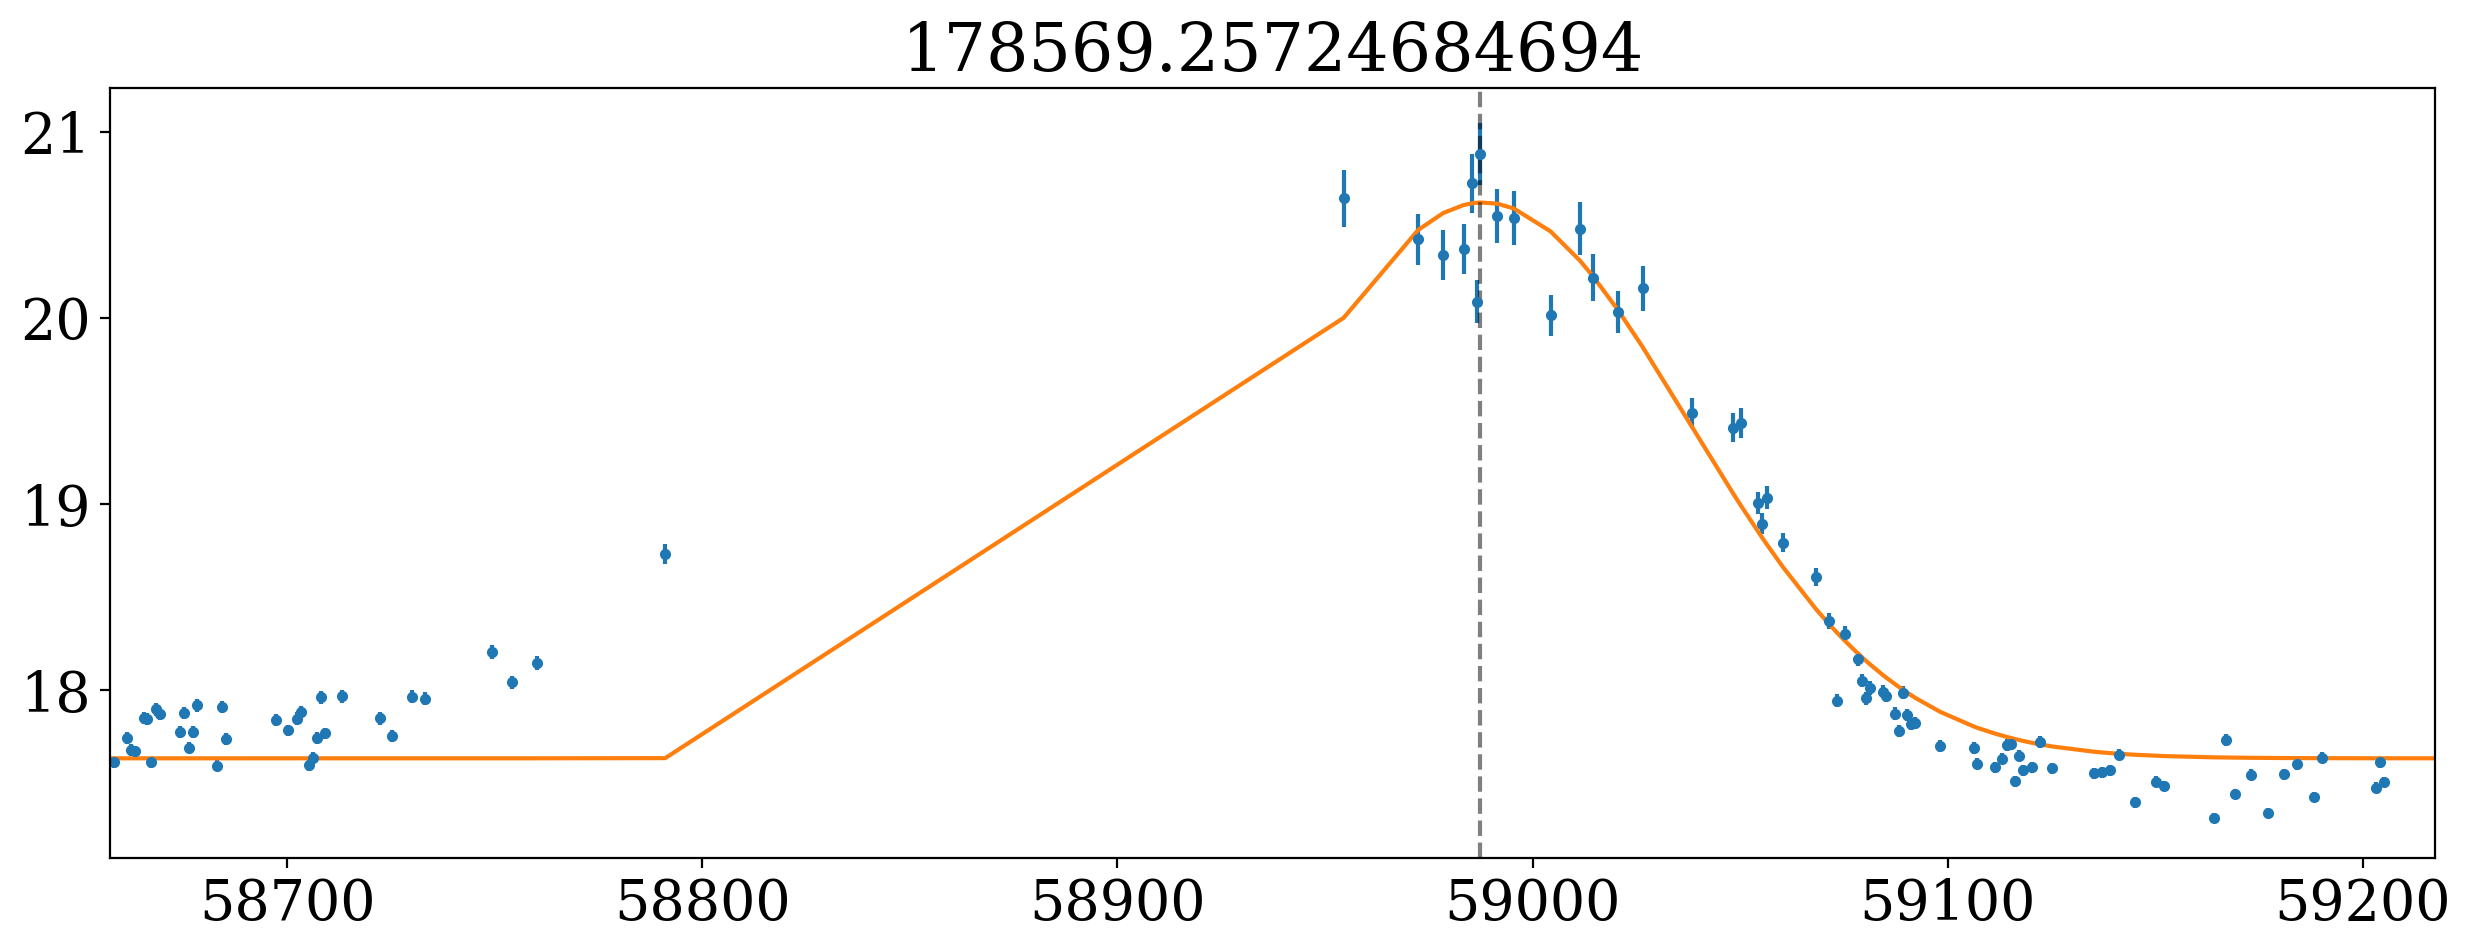

In [1480]:

for i in range(peak_detections[0]):
    plt.figure(figsize=(15,5))
    plt.errorbar(x, y, z, fmt='.')
    event = peak_detections[1][f'dip_{i}']
    
    try:
        pp = auto_fit(x, y, event['peak_loc'], R, return_model=True)
    except:
        continue
    
    plt.plot(x, pp)
    
    plt.axvline(event['peak_loc'], color='k', ls='--', alpha=0.5)
    
    plt.xlim(event['peak_loc']-330, event['peak_loc']+230)
    plt.title(calc_sum_score(x, y, peak_detections, R, S))


In [ ]:
# feature evaluation 
column_names = ['Nphot',
    'biweight_scale',
    'frac_above_2_sigma', # in deviation
    'Ndips',
    'rate',
    'chi2dof',
    'skew', 
    'kurtosis',
    'mad',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',    
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'lc_score']

In [1481]:
def evaluate(time_cat, mag_cat, mag_err_cat, flag_cat, band_cat, custom_cols=column_names, min_phot=10):
    """Evaluate time series."""

    # Summary information
    summary_ = {}
    
    # Digest my light curve. Select band, good detections & sort
    time, mag, mag_err = prepare_lc(time_cat, mag_cat, mag_err_cat, flag_cat, band_cat,  band_of_study='r', flag_good=0, q=None, custom_q=False)

    # Don't evaluate if there are less than 10 detections
    if len(time) < min_phot:
        summary_['Nphot'] = len(time)
        for col in custom_cols[1::]:
            summary_[col] = np.nan
    else:
        # Evaluate biweight location and scale & other obvious statistics
        R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)
        chi2dof = chidof(mag) # chi2dof

        # Running deviation
        running_deviation = deviation(mag, mag_err, R, S)

        # Peak detection summary per light curve
        peak_detections = peak_detector(time, running_deviation, power_thresh=4, peak_close_rmv=20, pk_2_pk_cut=20)

        # Calculate other summary statistics
        other_stats = other_summary_stats(time, mag, mag_err, len(mag), R, S)
            
        # If there's no detected peaks or time array is empty or no peaks detected...
        if peak_detections[0]==0 or len(time)==0 or peak_detections[0]==0:
            # If failing; set all values to NaN
            for col in custom_cols:
                summary_[col] = np.nan
            
            # Replace nan's with values
            summary_['Nphot'] = len(time)
            summary_['biweight_scale'] = S

            if len(running_deviation)==0:
                summary_['frac_above_2_sigma'] = 0
            else:
                summary_['frac_above_2_sigma'] = len(running_deviation[running_deviation>np.mean(running_deviation)+2*np.std(running_deviation)])/len(running_deviation)
            
            summary_['Ndips'] = 0
            summary_['rate'] = 0
            summary_['chi2dof'] = chi2dof
            summary_['skew'] = other_stats['skew']
            summary_['kurtosis'] = other_stats['kurtosis']
            summary_['mad'] = other_stats['mad']
            summary_['stetson_i'] = other_stats['stetson_I']
            summary_['stetson_j'] = other_stats['stetson_J']
            summary_['stetson_k'] = other_stats['stetson_K']
            summary_['invNeumann'] = other_stats['invNeumann']
        else: # If there are significant peaks...
            
            # From the r-band data select a good peak...
            bp = best_peak_detector(peak_detections, min_in_dip=3)
            
            # Investigate the g-band data and ensure we see a ~significant~ event 
            g_validate, out_g = False, 0
            
            time_g, mag_g, mag_err_g = prepare_lc(time_cat, mag_cat, mag_err_cat,
                                                   flag_cat, band_cat, band_of_study='g', flag_good=0, q=None, custom_q=False)
            
            # minimum number of g-band detections after processing
            if len(time_g) > 10:
                g_validate = True
                
            Rg, Sg = astro_stats.biweight.biweight_location(mag_g), astro_stats.biweight.biweight_scale(mag_g)
            
            running_deviation_g = deviation(mag_g, mag_err_g, Rg, Sg)
            
            # Select g-band detections at bp and expand by ~3 days
            xg, yg, yerrg = digest_the_peak(bp, time_g, running_deviation_g, mag_err_g, expandby=3) 
            
            if len(xg) == 0: # reject if there's no detections...
                g_validate = False
            else:
                g_validate = True
                # Calculate the significance of this g-band bump...
                out_g = (np.mean(yg)-np.mean(running_deviation_g))/(np.std(running_deviation_g))

            #TODO: check if 1.5 sigma is okay for now...
            if g_validate and out_g >1.5: # both r-band and g-band data show similar peaks...
                
                _score_ = calc_sum_score(time, mag, peak_detections, R, S)
                
                ######## Final appending data ########
                summary_['lc_score'] = _score_
                summary_['Ndips'] = peak_detections[0] # number of peaks
                summary_['rate'] = peak_detections[0]/(time[-1]-time[0])
                summary_['best_dip_power'] = bp['dip_power'].values[0]
                summary_['best_dip_time_loc'] = bp['peak_loc'].values[0]
                summary_['best_dip_start'] = bp['window_start'].values[0]
                summary_['best_dip_end'] = bp['window_end'].values[0]
                summary_['best_dip_dt'] = bp['average_dt_dif'].values[0]
                summary_['best_dip_ndet'] = bp['N_in_dip'].values[0]
                summary_['Nphot'] = len(time)
                summary_['biweight_scale'] = S
                if len(running_deviation)==0:
                    summary_['frac_above_2_sigma'] = 0
                else:
                    summary_['frac_above_2_sigma'] = len(running_deviation[running_deviation>np.mean(running_deviation)+2*np.std(running_deviation)])/len(running_deviation)
                summary_['Ndips'] = peak_detections[0] # number of peaks
                summary_['rate'] = peak_detections[0]/(time[-1]-time[0])
                summary_['chi2dof'] = chi2dof
                summary_['skew'] = other_stats['skew']
                summary_['kurtosis'] = other_stats['kurtosis']
                summary_['mad'] = other_stats['mad']
                summary_['stetson_i'] = other_stats['stetson_I']
                summary_['stetson_j'] = other_stats['stetson_J']
                summary_['stetson_k'] = other_stats['stetson_K']
                summary_['invNeumann'] = other_stats['invNeumann']
            
            else:
                # If failing; set all values to NaN
                for col in custom_cols:
                    summary_[col] = np.nan
                    
                summary_['Nphot'] = len(time)
                summary_['biweight_scale'] = S
                if len(running_deviation)==0:
                    summary_['frac_above_2_sigma'] = 0
                else:
                    summary_['frac_above_2_sigma'] = len(running_deviation[running_deviation>np.mean(running_deviation)+2*np.std(running_deviation)])/len(running_deviation)
                summary_['Ndips'] = peak_detections[0] # number of peaks
                summary_['rate'] = peak_detections[0]/(time[-1]-time[0])
                summary_['chi2dof'] = chi2dof
                summary_['skew'] = other_stats['skew']
                summary_['kurtosis'] = other_stats['kurtosis']
                summary_['mad'] = other_stats['mad']
                summary_['stetson_i'] = other_stats['stetson_I']
                summary_['stetson_j'] = other_stats['stetson_J']
                summary_['stetson_k'] = other_stats['stetson_K']
                summary_['invNeumann'] = other_stats['invNeumann']
                
    return pd.Series(list(summary_.values()), index=custom_cols)

NameError: name 'column_names' is not defined